# Import Data

In [323]:
import pandas as pd
import numpy as np
from itertools import chain
import seaborn as sns
import re
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [1801]:
badata = pd.read_csv('bonapp.csv')
badata['Published'] = pd.to_datetime(badata['Published'])
badata["Ingredients"] = badata["Ingredients"].apply(lambda x: x.split(','))

## Clean Ingredients
**This cleans various names for the same ingredient**

In [1841]:
def washIngredients(recipe):
    trimmed_lines = [ingred.lower() for ingred in recipe if not re.search('^preferably |^cut on |^be found |^into |^like |^on the |^ ?and/?o?r? |^lightly .* with .*a|^soaked|^thinly |^halved|^shaved for|^shaved into|^shaved with|^split|^sliced .*into|^sliced.*thick|^beaten |ground$|boneless$|^broken into|room temperature$|^cut into|^plus more ?f?o?r? ?.*|ed$', ingred)]
    removed_num = [re.sub('\.|\W+-|\W+—|\W+–|\d+-|\*|"|”|;.*| \(.*\)|\(|\)|½|¾|¼|⅓|⅔|⅛', '', ele) for ele in trimmed_lines]
    removed_kitchen_words = [re.sub('coarsely |is avail.*|are avail.*|knob of | a mix of .*|^firm but |^firmly packed| slices| spears|^shredded |^torn|^and |granulated |^roasted |^asian$|fresh |leaves|skinless|cloves?|slices?d? |with .*stems|chilled |chopped |online|finely |grated |freshly |peeled |sprigs |pestle|such as .*|other |bar spoon |thinly |finely chopped|low.?sodium ', '', ele) for ele in removed_num]
    removed_measurements = [re.sub('\d+|tbsp |cups? |oz |bottle |light |envelope |packages? |found in.*|bunch |online|small |medium |large |pinch of | cans? |pints? | ?inch pieces? |inch.*thick| lengthwise|dashes |^plus |tbsp. |oz. |teaspoons? |tsp |tablespoons? |ounces? |pounds? |^ |^\n', '', ele) for ele in removed_kitchen_words]
    removed_num = [re.sub('\.|\W+-|\W+—|\W+–|\d+-|\*|"|”|;.*| \(.*\)|\(|\)|½|¾|¼|⅓|⅔|⅛', '', ele) for ele in removed_measurements]
    removed_kitchen_words = [re.sub('coarsely |skin.?on | ?fillets?|center.?cut |^boneless |^new$| slices| spears|^heads? o?f? ?|^torn|^and|granulated |^crisp |^tart |^one |^ripe |t.i.*cut |^asian$|fresh |leaves|skinless|cloves?|slices?d? |with .*stems|chilled |chopped |online|finely |at .* markets.*|from a .*|grated |freshly |peeled |sprigs |pestle|such as .*|other |bar spoon |finely chopped|low.?sodium ', '', ele) for ele in removed_num]
    removed_measurements = [re.sub('\d+|cups? |^dash |oz |^lb |bottle |^liter | is a .*| threads$|^like |^scoops? |cut into.*|^seadless | twist$| zest$|^shell.*on |handful o?f? ?|^bowls$|^clear$|envelope ?|packages? |bunch | stalks$|online|small |medium |large |^shaved |pinch of | cans? |pints? | ?inch pieces? | pieces$|inch.*thick|^inch.* | lengthwise|dashes |^plus |tbsp. |oz. |teaspoons? |tsp |tablespoons? |ounces? |pounds? |^ |^\n', '', ele) for ele in removed_kitchen_words]
    return removed_measurements
    
def chopIngredients(recipe):
    split_lines = [ingred.strip().split(" or ") if ingred.count(' or ') > 0 else [ingred.strip()] for ingred in recipe]
    split_lines = list(chain.from_iterable(split_lines))
    second_split_lines = [ingred.split(" and ") if ingred.count(' and ') > 0 else [ingred] for ingred in split_lines]
    second_split_lines = list(chain.from_iterable(second_split_lines))
    return second_split_lines

def pealIngredients(recipe):
    dropped_ingreds = [ingred.strip() for ingred in recipe if ingred != '' and not re.search('^or |^more$|^more for|^for |^a |^find |^ainch|^into|^cut |^about|^any? |^in h|^and/or|^-|^–|^—', ingred)]
    dropped_ingreds_set = set(chain.from_iterable(badata['filtered_Ingreds']))
    new_dropped_ingreds = [ingred + 's' if ingred + 's' in dropped_ingreds_set else ingred + 'es' if ingred + 'es' in dropped_ingreds_set else ingred for ingred in dropped_ingreds]
    return new_dropped_ingreds

def simmerIngredients(recipe):
    ##flattens lemons, black pepper, eggs, olive oil, flour, oranges, pears, kale, anchovies
    reduced_ingreds = ['lemon' if re.search('lemons? |lemons?$', ingred) else 'ground black pepper' if \
                       ingred.count('ground pepper') > 0 else 'eggs' if ingred.count('egg ') > 0  else \
                       'lime' if ingred.count('lime') > 0 else 'olive oil' if ingred.count('olive oil') > 0 else \
                       'all-purpose flour' if re.search('all.* flour', ingred) else 'blood oranges' if \
                       ingred.count('blood orange') > 0 else 'oranges' if re.search(' orange$| orange |orange w|orange .*u', ingred) else \
                       'pears' if re.search(' ?pears?$', ingred) else 'kale' if re.search(' kale', ingred) \
                       else 'anchovy fillets' if ingred.count('anchovy') > 0 else ingred for ingred in recipe ]
    repeated_ingreds = list(set(reduced_ingreds))
    return repeated_ingreds

In [1852]:
badata["filtered_Ingreds"] = badata["Ingredients"].copy()
badata['filtered_Ingreds'] = badata['filtered_Ingreds'].apply(washIngredients)
badata['filtered_Ingreds'] = badata['filtered_Ingreds'].apply(chopIngredients)
badata['filtered_Ingreds'] = badata['filtered_Ingreds'].apply(washIngredients)
badata['filtered_Ingreds'] = badata['filtered_Ingreds'].apply(pealIngredients)
badata['filtered_Ingreds'] = badata['filtered_Ingreds'].apply(simmerIngredients)

In [1846]:
# badata["Reviews"]

In [1847]:
# badata['filtered_Ingreds'][416]

In [1848]:
# badata.Ingredients[416]

## Expanding of Dataframe to Ingredients
**This will zip and repeat recipe titles for each of their ingredients** 

Results in `df_ingred` dataframe

In [ ]:
df_ingred = badata.copy()

index=0
list_ = []
for item in df_ingred.filtered_Ingreds:
    list_.extend(map(lambda x: [index, x], item))
    index += 1
mini_ingred = pd.DataFrame(list_, columns=['index', 'ingred'])
df_ingred = pd.merge(df_ingred.drop('filtered_Ingreds', axis = 1), mini_ingred, \
                     how="right", left_index=True, right_on='index')
df_ingred = df_ingred.drop(["Ingredients", "Instructions", 'index'], axis=1).sort_values(['Published', "DishTitle"]).reset_index()
df_ingred.columns = df_ingred.columns.str.lower()

In [1854]:
df_ingred.to_csv(r"./bonapp_df.csv")

In [1855]:
badata.to_csv(r"./full_bonapp_df.csv")

In [1805]:
# ingred_list = df_ingred.groupby('ingred')["DishTitle"].count()
# ingred_list = list(sorted(ingred_list.index))
# list(filter(lambda x: re.search('smoked', x), ingred_list))
# print(ingred_list)

In [1890]:
df_ingred.head()

,index,dishtitle,published,rating,reviews,ingred
0,12609,"5-Grain Porridge with Bee Pollen, Apples, and ...",2015-01-01,2.7,NaN,wheat bran
1,12610,"5-Grain Porridge with Bee Pollen, Apples, and ...",2015-01-01,2.7,NaN,brown rice
2,12611,"5-Grain Porridge with Bee Pollen, Apples, and ...",2015-01-01,2.7,NaN,bee pollen
3,12612,"5-Grain Porridge with Bee Pollen, Apples, and ...",2015-01-01,2.7,NaN,ground cinnamon
4,12613,"5-Grain Porridge with Bee Pollen, Apples, and ...",2015-01-01,2.7,NaN,millet


## Parse Reviews
**This will use NPL to filter unnecessary words, and frequency count remaining words**

In [ ]:
for review in badata["Reviews"]:
    if review != 

In [1717]:
badata["Reviews"][1] == "NaN"

False

## Analyze Adjustments in Covid Recipes

### Beginning Plots

In [1762]:
df_ingred.groupby('ingred')[['DishTitle']].count().sort_values(by='DishTitle', ascending=False)[:20]

,DishTitle
ingred,
kosher salt,2571
olive oil,1398
garlic,1218
ground black pepper,1199
lemon,949
sugar,702
eggs,641
unsalted butter,632
vegetable oil,473


In [1763]:
df_ingred.groupby('ingred')[['DishTitle']].count().sort_values(by='DishTitle')[160:190]

,DishTitle
ingred,
of cilantro,1
of dill,1
of hot sauce,1
of parsley,1
of red radishes,1
of scallions,1
of spinach,1
of swiss chard,1
of tabasco,1


(array([3832., 4428., 4604., 4588., 4654., 4153., 2730., 3314., 2522.,
        2285.]),
 array([735599. , 735793.7, 735988.4, 736183.1, 736377.8, 736572.5,
        736767.2, 736961.9, 737156.6, 737351.3, 737546. ]),
 <a list of 10 Patch objects>)

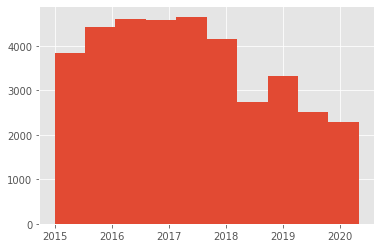

In [1901]:
plt.hist(df_ingred['published'])

(array([170.,   0., 233.,   0., 350.,   0.,   0., 193.,   0., 259.]),
 array([737425. , 737437.1, 737449.2, 737461.3, 737473.4, 737485.5,
        737497.6, 737509.7, 737521.8, 737533.9, 737546. ]),
 <a list of 10 Patch objects>)

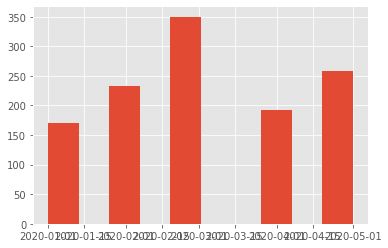

In [1902]:
df_2020 = (df_ingred[(df_ingred['published'] > pd.to_datetime("2019-12-01"))])
plt.hist(df_2020['published'])

In [1889]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
from plotly.graph_objs import Figure, Histogram, Layout

min_ = df_2020['published'].min()
max_ = df_2020['published'].max()

data = [Histogram(x=df_2020['published'], 
                  xbins=dict(start=min_,
                             end=max_))]
                             #size=(max_-min_)/2))]
layout = Layout(title="Histogram of March Recipes",
                bargap=0.20)
fig = Figure(data=data, layout=layout)

plotly.offline.iplot(fig, show_link=False, image_width=600, image_height=400)

In [1893]:
from plotly.graph_objs import Scatter

data = [Scatter(x=df_ingred['published'], y=df_ingred['rating'], mode = 'markers')]#, text=df['movie_title'])]
layout = Layout(title="Gross Income vs Budget")

fig = Figure(data=data, layout=layout)

plotly.offline.iplot(fig, show_link=False)

In [1861]:
(df_ingred['published'] > pd.to_datetime("2016-01-01"))

0        False
1        False
2        False
3        False
4        False
         ...  
37115    False
37116    False
37117    False
37118    False
37119    False
Name: published, Length: 37120, dtype: bool

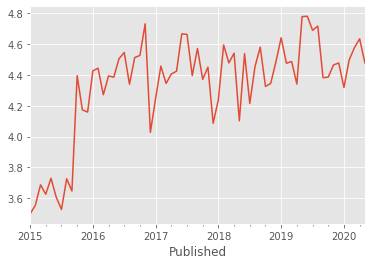

In [1833]:
df_ingred.groupby('Published')['Rating'].mean().plot()

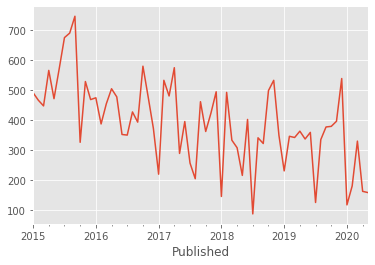

In [1767]:
df_ingred.groupby('Published')['Rating'].count().plot()

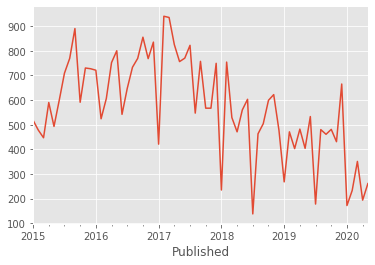

In [1769]:
df_ingred.groupby('Published')['ingred'].count().plot()

In [1775]:
# df_ingred.loc[df_ingred['ingred'].isin(['kale'])].groupby('Published')['DishTitle'].count().plot()
df_ingred.loc[df_ingred['ingred'] == 'kale'].groupby('Published')['DishTitle'].count().plot()

TypeError: search() takes from 2 to 3 positional arguments but 37184 were given

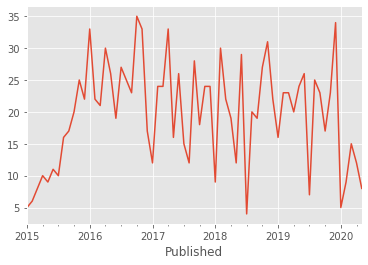

In [1777]:
badata.loc[badata["Rating"] > 4].groupby('Published')['DishTitle'].count().plot()

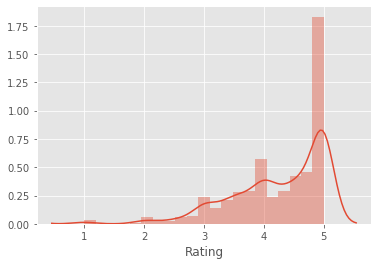

In [1778]:
sns.distplot(badata['Rating'])

Text(0.5, 1.0, 'Histogram of Recipes from 2015 - 2020')

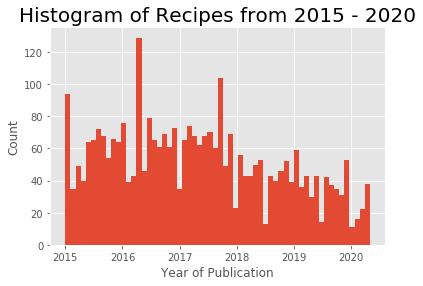

In [1782]:
plt.hist(badata['Published'], bins=60)
plt.xlabel('Year of Publication')
plt.ylabel('Count')
plt.title('Histogram of Recipes from 2015 - 2020', fontsize=20)

Text(0.5, 1.0, 'Scatterplot of Rating per Month, 2015')

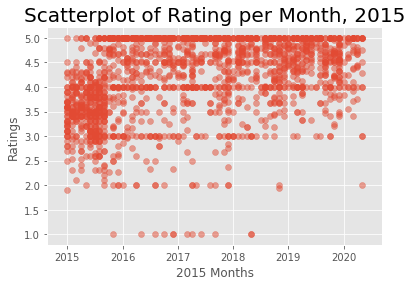

In [1783]:
plt.scatter(badata['Published'], badata["Rating"], alpha=.5)
plt.xlabel('2015 Months')
plt.ylabel('Ratings')
plt.title('Scatterplot of Rating per Month, 2015', fontsize=20)

In [1786]:
badata[["Rating", "Published"]]

,Rating,Published
0,3.00,2015-01-01
1,NaN,2018-05-01
2,4.33,2018-04-01
3,4.50,2018-03-01
4,4.00,2018-02-01
...,...,...
3143,5.00,2016-04-01
3144,2.00,2016-04-01
3145,NaN,2016-04-01
3146,3.02,2016-03-01
